### Import required packages:

In [2]:
import numpy as np
import astropy.io.fits
import random
import os
import os.path
from collections import Counter
from PIL import Image
from sklearn.cluster import KMeans
from astropy.time import Time
import csv
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import cudf
from cuml.cluster import DBSCAN
from cuml.cluster import KMeans as cudkmean
import timeit

### Functions:


In [3]:

# Normalizing between [1,-1]
def normal(a):
    
    aa = a - a.min()
    bb = a.max() - a.min()
    cc = (2 * aa) / bb
    dd = cc - 1
    return dd

# Getting Features

def getFeatures(Name):
    fileData = astropy.io.fits.open(Name)
    B = fileData[1].data
    B = np.array(B, dtype=np.float32)
    Binc = fileData[2].data
    Binc = np.array(Binc, dtype=np.float32)
    Bazi = fileData[3].data
    Bazi = np.array(Bazi, dtype=np.float32)
    DopF = fileData[4].data
    DopF = np.array(DopF, dtype=np.float32)
    #DopS = fileData[5].data
    #DopS = np.array(DopS, dtype=np.float64)
    SLFF = fileData[12].data
    SLFF = np.array(SLFF, dtype=np.float32)
    CI = fileData[32].data
    CI = np.array(CI, dtype=np.float32)


    return B, Binc, Bazi, DopF, SLFF, CI


# Removing that effect due to doppler shifts

def canNoise(Doppler):
    
    y = np.mean(Doppler, 0)
    x = np.array(range(Doppler.shape[1]))
    m, b = np.polyfit(x, y, 1)
    v = m*x + b
    out = Doppler - v

    return out

# Normalizing angles

def normangle(feature):
    
    
    a = np.cos(np.deg2rad(feature))
    
    return a

# Concatenating all the observations

def concatfeatures(NewList):

    Btot, Binctot, DopFtot, SLFFtot, CItot = np.array([]), np.array([]),np.array([]), np.array([]),np.array([])



    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        Btot = np.concatenate((Btot, B), axis=None)
        Binctot = np.concatenate((Binctot, Binc), axis=None)
        DopFtot = np.concatenate((DopFtot, canNoise(DopF)), axis=None)
        SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
        CItot = np.concatenate((CItot, CI), axis=None)
    
    
    return Btot, Binctot, DopFtot, SLFFtot, CItot



### Preprocessing:

In [4]:
# Reading our files in related directory
NorthDir='/glade/work/egeland/hinode_synoptic/north'
allfiles = [os.path.join(NorthDir, f) for f in sorted(os.listdir(NorthDir))]

# Removing all sav files
NewList=[item for i,item in enumerate(allfiles) if i%2==0]
b = []

#Getting only fastmaps
for item in NewList:
    
    fileData = astropy.io.fits.open(item)
    a = fileData[0].header['YSCALE']
    if a > 0.16 :
        b.append(item)
        
NewList = b

# concatenating all samples(pixels) in each feature
Btot, Binctot, DopFtot, SLFFtot, CItot = concatfeatures(NewList)

for it, item in enumerate(Btot):
    
    if item < 200:
        
        Btot[it] = 0
        Binctot[it] = 90
        SLFFtot[it] = 0
        
    elif item > 2000:
        
        Btot[it] = 2000
        
        

# Normalizing Features
Btotn = normal(Btot)
Binctotn = normangle(Binctot)
DopFtotn = normal(DopFtot)
SLFFtotn = normal(SLFFtot)
CItotn = normal(CItot)

# Preparing the input for our clustering method
da = np.array([Btotn, Binctotn, DopFtotn, SLFFtotn, CItotn])
fda = np.transpose(da)

In [4]:
# transfer the data to cudf for using cuda
cudf.set_allocator("managed")
X_df = pd.DataFrame({'fea%d'%i: fda[:, i] for i in range(fda.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

print(X_gpu)

          fea0          fea1      fea2  fea3      fea4
0         -1.0  6.123234e-17 -0.115495  -1.0 -0.450234
1         -1.0  6.123234e-17 -0.094160  -1.0 -0.403435
2         -1.0  6.123234e-17 -0.153336  -1.0 -0.300402
3         -1.0  6.123234e-17 -0.158472  -1.0 -0.338802
4         -1.0  6.123234e-17 -0.117647  -1.0 -0.446365
...        ...           ...       ...   ...       ...
22620155  -1.0  6.123234e-17  0.005380  -1.0 -0.694710
22620156  -1.0  6.123234e-17 -0.024582  -1.0 -0.701551
22620157  -1.0  6.123234e-17 -0.075808  -1.0 -0.708145
22620158  -1.0  6.123234e-17 -0.107269  -1.0 -0.726295
22620159  -1.0  6.123234e-17 -0.068694  -1.0 -0.704469

[22620160 rows x 5 columns]


Time:  542.7064000299433


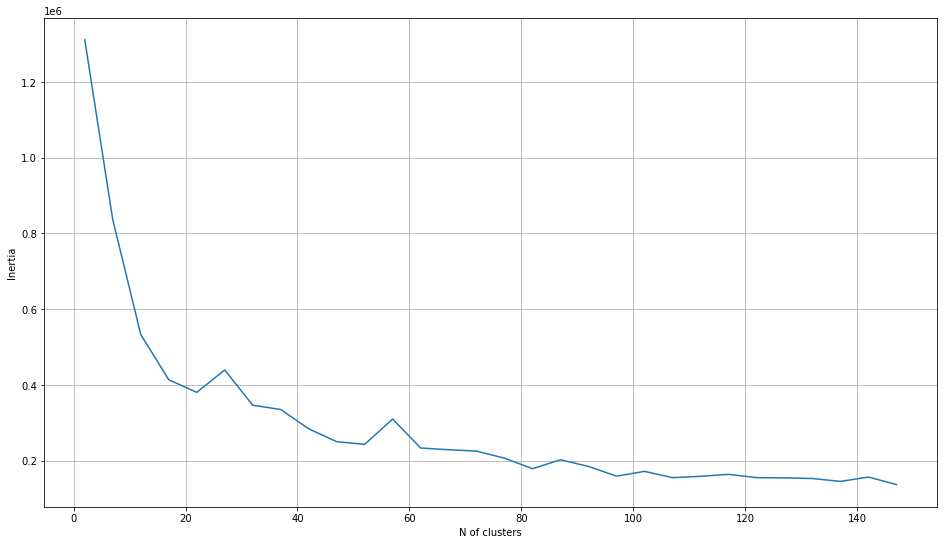

In [5]:
# Calculating number of clusters based on Inertia for Kmeans
kk = np.array(range(2,151,5))
inlist = np.array([])

start = timeit.default_timer()
for k in kk:

    cud = cudkmean(n_clusters = k)
    cud.fit(X_gpu)
    inert = cud.score(X_gpu)
    inlist = np.append(inlist, inert)

stop = timeit.default_timer()
print('Time: ', stop - start) 


plt.figure(figsize=(16,9))
plt.xlabel('N of clusters')
plt.ylabel('Inertia')
plt.plot(kk, np.abs(inlist))
plt.grid(True)
plt.show()




#### It sounds 22 is optimal number of clusters based on Inertia in elbow method!

Time:  7039.4958963029785


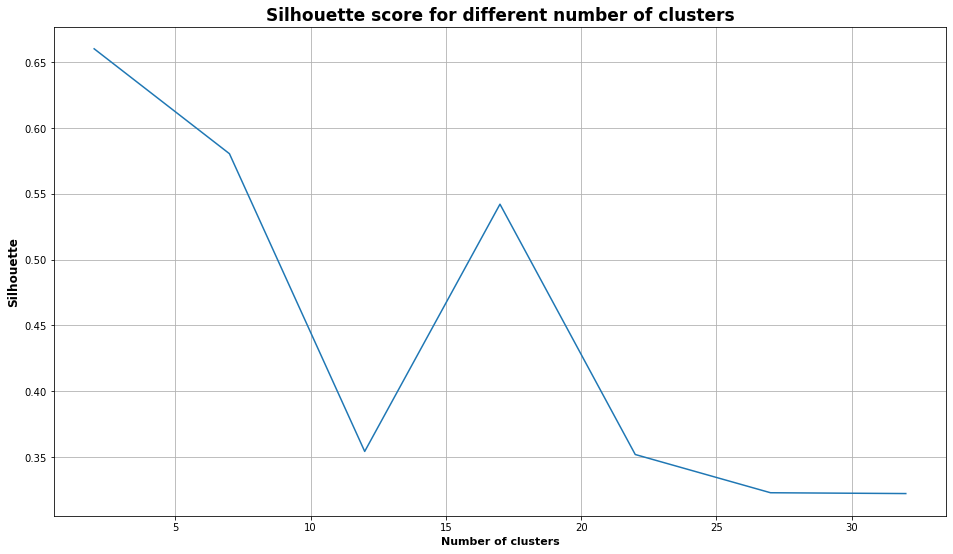

In [12]:
# Calculating number of clusters based on 100k samples for silhouette- Kmeans
# silhouette will be calculated for 100k samples out of 20million samples through 5 iterations
# the mean for these 5 iterations will be considered!

dade = fda[np.random.choice(fda.shape[0], 300000, replace=False), :]
X_df = pd.DataFrame({'fea%d'%i: dade[:, i] for i in range(dade.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

kk = np.array(range(2,35,5))
sillist = np.array([])

start = timeit.default_timer()
for k in kk:

    cud = cudkmean(n_clusters = k)
    cud.fit(X_gpu)
    labels = cud.labels_
    labbels = labels.to_array()
    silit = np.array([])
    silhouette_avg = silhouette_score(dade, labbels)
    sillist = np.append(sillist, silhouette_avg)

stop = timeit.default_timer()
print('Time: ', stop - start) 


plt.figure(figsize=(16,9))
plt.xlabel('Number of clusters', fontsize=11, fontweight='bold')
plt.ylabel('Silhouette', fontsize=12, fontweight='bold')
plt.plot(kk, sillist)
plt.grid(True)
plt.title('Silhouette score for different number of clusters', fontsize=17, fontweight='bold')

plt.savefig('ncl300k.png')

### I will add results for 3 different run for 1million samples! 
### However, all the graphs shows that after 22-24 clusters silhouette or Inertia changes in a way that optimal number of clusters cannot be after that!

For n_clusters = 2 The average silhouette_score is : 0.6615370687810049
For n_clusters = 7 The average silhouette_score is : 0.35254448481384826
For n_clusters = 12 The average silhouette_score is : 0.5635333331383332
For n_clusters = 17 The average silhouette_score is : 0.35271575724007453
For n_clusters = 22 The average silhouette_score is : 0.3238253814722808


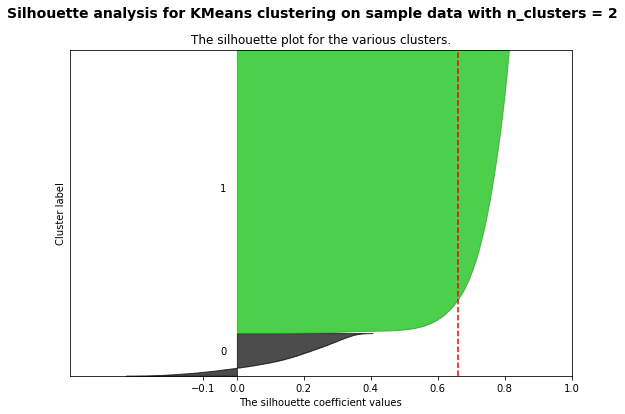

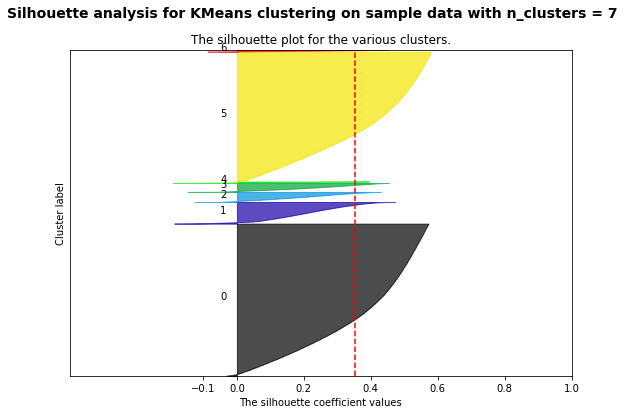

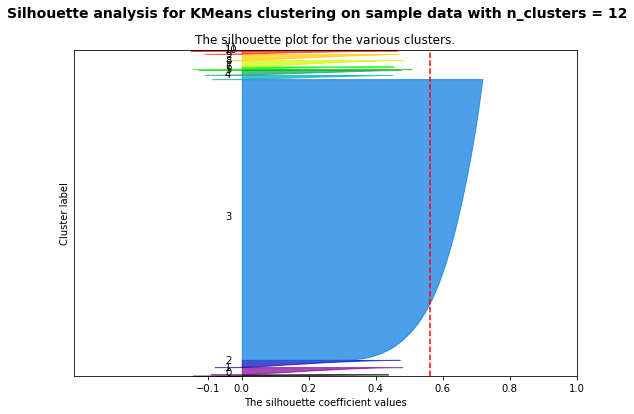

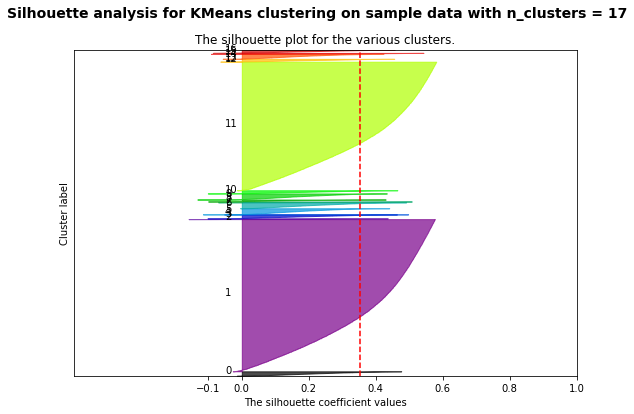

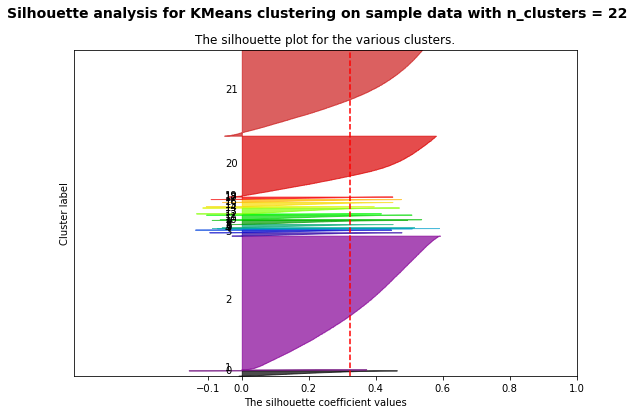

In [7]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


dade = fda[np.random.choice(fda.shape[0], 200000, replace=False), :]
X_df = pd.DataFrame({'fea%d'%i: dade[:, i] for i in range(dade.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

range_n_clusters = [2, 7, 12, 17, 22]
#range_n_clusters = [2, 7, 12]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(9, 6)
    ax1.set_xlim([-0.5, 1])
    
    ax1.set_ylim([0, 200000 + (n_clusters + 4) * 10])
    
    cud = cudkmean(n_clusters = n_clusters)
    cud.fit(X_gpu)
    labels = cud.labels_
    cluster_labels = labels.to_array()

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dade, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dade, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()